In [1]:
from google.colab import drive
drive.mount('/content/drive/')

!cp "/content/drive/My Drive/Dissertation/envs/point_maze.py" .

Mounted at /content/drive/


In [2]:
# for inference, not continued training
def save_model(model, name):
    path = f"/content/drive/My Drive/Dissertation/saved_models/point_maze_hdqn/{name}" 

    torch.save({
      'meta_controller': model.meta_controller.state_dict(),
      'controller': {
          'critic': model.controller.critic.state_dict(),
          'actor': model.controller.actor.state_dict(),
      }
    }, path)

import copy
def load_model(model, name, dir="point_maze_hdqn"):
    path = f"/content/drive/My Drive/Dissertation/saved_models/{dir}/{name}" 
    checkpoint = torch.load(path)

    #model.meta_controller.critic.load_state_dict(checkpoint['meta_controller']['critic'])
    #model.meta_controller.critic_target = copy.deepcopy(model.meta_controller.critic)
    #model.meta_controller.actor.load_state_dict(checkpoint['meta_controller']['actor'])
    #model.meta_controller.actor_target = copy.deepcopy(model.meta_controller.actor)

    model.meta_controller.load_state_dict(checkpoint['meta_controller'])
    model.meta_controller_target = copy.deepcopy(model.meta_controller)

    model.controller.critic.load_state_dict(checkpoint['controller']['critic'])
    model.controller.critic_target = copy.deepcopy(model.controller.critic)
    model.controller.actor.load_state_dict(checkpoint['controller']['actor'])
    model.controller.actor_target = copy.deepcopy(model.controller.actor)

    # model.eval() for evaluation instead
    model.eval()
    model.meta_controller.eval()
    model.controller.eval()

In [3]:
%matplotlib inline

import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

from IPython import display
plt.ion()

# if gpu is to be used
device = torch.device("cuda")

In [4]:
class NormalizedEnv(gym.ActionWrapper):
    """ Wrap action """

    def action(self, action):
        act_k = (self.action_space.high - self.action_space.low)/ 2.
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k * action + act_b

    def reverse_action(self, action):
        act_k_inv = 2./(self.action_space.high - self.action_space.low)
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k_inv * (action - act_b)

In [5]:
from point_maze import PointMazeEnv 
env = NormalizedEnv(PointMazeEnv(4))

***

In [6]:
# [reference] https://github.com/matthiasplappert/keras-rl/blob/master/rl/random.py

class RandomProcess(object):
    def reset_states(self):
        pass

class AnnealedGaussianProcess(RandomProcess):
    def __init__(self, mu, sigma, sigma_min, n_steps_annealing):
        self.mu = mu
        self.sigma = sigma
        self.n_steps = 0

        if sigma_min is not None:
            self.m = -float(sigma - sigma_min) / float(n_steps_annealing)
            self.c = sigma
            self.sigma_min = sigma_min
        else:
            self.m = 0.
            self.c = sigma
            self.sigma_min = sigma

    @property
    def current_sigma(self):
        sigma = max(self.sigma_min, self.m * float(self.n_steps) + self.c)
        return sigma


# Based on http://math.stackexchange.com/questions/1287634/implementing-ornstein-uhlenbeck-in-matlab
class OrnsteinUhlenbeckProcess(AnnealedGaussianProcess):
    def __init__(self, theta, mu=0., sigma=1., dt=1e-2, x0=None, size=1, sigma_min=None, n_steps_annealing=1000):
        super(OrnsteinUhlenbeckProcess, self).__init__(mu=mu, sigma=sigma, sigma_min=sigma_min, n_steps_annealing=n_steps_annealing)
        self.theta = theta
        self.mu = mu
        self.dt = dt
        self.x0 = x0
        self.size = size
        self.reset_states()

    def sample(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + self.current_sigma * np.sqrt(self.dt) * np.random.normal(size=self.size)
        self.x_prev = x
        self.n_steps += 1
        return x

    def reset_states(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros(self.size)

In [7]:
def soft_update(target, source, tau):
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(
            target_param.data * (1.0 - tau) + param.data * tau
        )

def hard_update(target, source):
    for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(param.data)

In [8]:
# (state, action) -> (next_state, reward, done)
transition = namedtuple('transition', ('state', 'action', 'next_state', 'reward', 'done'))

# replay memory D with capacity N
class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    # implemented as a cyclical queue
    def store(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        
        self.memory[self.position] = transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
  
# (state, action) -> (next_state, reward, done)
transition_meta = namedtuple('transition', ('state', 'action', 'next_state', 'reward', 'done', 'state_seq', 'action_seq'))

# replay memory D with capacity N
class ReplayMemoryMeta(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    # implemented as a cyclical queue
    def store(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        
        self.memory[self.position] = transition_meta(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

***

In [9]:
DEPTH = 128

class Actor(nn.Module):
    def __init__(self, nb_states, nb_actions):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(nb_states, DEPTH)
        self.fc2 = nn.Linear(DEPTH, DEPTH)
        self.head = nn.Linear(DEPTH, nb_actions)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.head(x))

class Critic(nn.Module):
    def __init__(self, nb_states, nb_actions):
        super(Critic, self).__init__()

        # Q1 architecture
        self.l1 = nn.Linear(nb_states + nb_actions, DEPTH)
        self.l2 = nn.Linear(DEPTH, DEPTH)
        self.l3 = nn.Linear(DEPTH, 1)

        # Q2 architecture
        self.l4 = nn.Linear(nb_states + nb_actions, DEPTH)
        self.l5 = nn.Linear(DEPTH, DEPTH)
        self.l6 = nn.Linear(DEPTH, 1)
    
    def forward(self, state, action):
        sa = torch.cat([state, action], 1).float()

        q1 = F.relu(self.l1(sa))
        q1 = F.relu(self.l2(q1))
        q1 = self.l3(q1)

        q2 = F.relu(self.l4(sa))
        q2 = F.relu(self.l5(q2))
        q2 = self.l6(q2)
        return q1, q2

    def Q1(self, state, action):
        sa = torch.cat([state, action], 1).float()

        q1 = F.relu(self.l1(sa))
        q1 = F.relu(self.l2(q1))
        q1 = self.l3(q1)
        return q1

In [10]:
BATCH_SIZE = 64
GAMMA = 0.99

# https://spinningup.openai.com/en/latest/algorithms/td3.html
class TD3(nn.Module):
    def __init__(self, nb_states, nb_actions, is_meta=False):
        super(TD3, self).__init__()
        self.nb_states = nb_states
        self.nb_actions= nb_actions
        
        self.actor = Actor(self.nb_states, self.nb_actions)
        self.actor_target = Actor(self.nb_states, self.nb_actions)
        self.actor_optimizer  = optim.Adam(self.actor.parameters(), lr=0.0001)

        self.critic = Critic(self.nb_states, self.nb_actions)
        self.critic_target = Critic(self.nb_states, self.nb_actions)
        self.critic_optimizer  = optim.Adam(self.critic.parameters(), lr=0.0001)

        hard_update(self.actor_target, self.actor)
        hard_update(self.critic_target, self.critic)
        
        self.is_meta = is_meta

        #Create replay buffer
        self.memory = ReplayMemory(100000) if not self.is_meta else ReplayMemoryMeta(100000)
        self.random_process = OrnsteinUhlenbeckProcess(size=nb_actions, theta=0.15, mu=0.0, sigma=0.2)

        # Hyper-parameters
        self.tau = 0.005
        self.depsilon = 1.0 / 50000
        self.policy_noise=0.2
        self.noise_clip=0.5
        self.policy_freq=2
        self.total_it = 0

        # 
        self.epsilon = 1.0
        self.is_training = True

    def update_policy(self, off_policy_correction=None):
        if len(self.memory) < BATCH_SIZE:
            return

        self.total_it += 1
        
        # in the form (state, action) -> (next_state, reward, done)
        transitions = self.memory.sample(BATCH_SIZE)

        if not self.is_meta:
            batch = transition(*zip(*transitions))
            action_batch = torch.cat(batch.action)
        else:
            batch = transition_meta(*zip(*transitions))

            action_batch = torch.cat(batch.action)
            state_seq_batch = torch.stack(batch.state_seq)
            action_seq_batch = torch.stack(batch.action_seq)

            action_batch = off_policy_correction(action_batch.cpu().numpy(), state_seq_batch.cpu().numpy(), action_seq_batch.cpu().numpy())
        
        state_batch = torch.cat(batch.state)
        next_state_batch = torch.cat(batch.next_state)
        reward_batch = torch.cat(batch.reward)
        done_mask = np.array(batch.done)
        not_done_mask = torch.from_numpy(1 - done_mask).float().to(device)

        # Target Policy Smoothing
        with torch.no_grad():
            # Select action according to policy and add clipped noise
            noise = (
                torch.randn_like(action_batch) * self.policy_noise
            ).clamp(-self.noise_clip, self.noise_clip).float()
            
            next_action = (
                self.actor_target(next_state_batch) + noise
            ).clamp(-1.0, 1.0).float()

            # Compute the target Q value
            # Clipped Double-Q Learning
            target_Q1, target_Q2 = self.critic_target(next_state_batch, next_action)
            target_Q = torch.min(target_Q1, target_Q2).squeeze(1)
            target_Q = (reward_batch + GAMMA * not_done_mask  * target_Q).float()
        
        # Critic update
        current_Q1, current_Q2 = self.critic(state_batch, action_batch)
      
        critic_loss = F.mse_loss(current_Q1, target_Q.unsqueeze(1)) + F.mse_loss(current_Q2, target_Q.unsqueeze(1))

        # Optimize the critic
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Delayed policy updates
        if self.total_it % self.policy_freq == 0:
            # Compute actor loss
            actor_loss = -self.critic.Q1(state_batch, self.actor(state_batch)).mean()
            
            # Optimize the actor 
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            # Target update
            soft_update(self.actor_target, self.actor, self.tau)
            soft_update(self.critic_target, self.critic, self.tau / 5)

    def eval(self):
        self.actor.eval()
        self.actor_target.eval()
        self.critic.eval()
        self.critic_target.eval()

    def observe(self, s_t, a_t, s_t1, r_t, done):
        self.memory.store(s_t, a_t, s_t1, r_t, done)

    def random_action(self):
        return torch.tensor([np.random.uniform(-1.,1.,self.nb_actions)], device=device, dtype=torch.float)

    def select_action(self, s_t, warmup, decay_epsilon):
        if warmup:
            return self.random_action()

        with torch.no_grad():
            action = self.actor(s_t).squeeze(0)
            #action += torch.from_numpy(self.is_training * max(self.epsilon, 0) * self.random_process.sample()).to(device).float()
            action += torch.from_numpy(self.is_training * max(self.epsilon, 0) * np.random.uniform(-1.,1.,1)).to(device).float()
            action = torch.clamp(action, -1., 1.)

            action = action.unsqueeze(0)
            
            if decay_epsilon:
                self.epsilon -= self.depsilon
            
            return action

class DQN(nn.Module):
    def __init__(self, inputs, outputs, mem_len = 100000):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(inputs, DEPTH)
        self.fc2 = nn.Linear(DEPTH, DEPTH)
        self.head = nn.Linear(DEPTH, outputs)
        
        self.memory = ReplayMemory(mem_len)

        self.n_actions = outputs
        self.steps_done = 0
        
        self.EPS_START = 1.0
        self.EPS_END = 0.0
        self.EPS_DECAY = 10000 # in number of steps
        self.TAU = 0.001

        self.eps_printed = False

        self.policy_update = 2
        self.tot_updates = 0

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.head(x)
    
    def act(self, state, warmup, is_training):
        if warmup: 
            return torch.tensor([[random.randrange(self.n_actions)]], device=device, dtype=torch.long)

        if is_training:
            eps_threshold = self.EPS_END + (self.EPS_START - self.EPS_END) * (1. - min(1., self.steps_done / self.EPS_DECAY))
            self.steps_done += 1

            if eps_threshold <= 0.2 and not self.eps_printed:
                self.eps_printed = True
                print("EPS_THRESHOLD below 0.2")

            # With probability eps select a random action
            if random.random() < eps_threshold:
                return torch.tensor([[random.randrange(self.n_actions)]], device=device, dtype=torch.long)

        # otherwise select action = maxa Q∗(φ(st), a; θ)
        with torch.no_grad():
            return self(state).max(1)[1].view(1, 1)
    
    def experience_replay(self, optimizer, target):
        if len(self.memory) < BATCH_SIZE:
            return

        self.tot_updates += 1
        
        # in the form (state, action) -> (next_state, reward, done)
        transitions = self.memory.sample(BATCH_SIZE)
        batch = transition(*zip(*transitions))
        
        state_batch = torch.cat(batch.state)
        next_state_batch = torch.cat(batch.next_state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        done_mask = np.array(batch.done)
        not_done_mask = torch.from_numpy(1 - done_mask).float().to(device)
        
        current_Q_values = self(state_batch).gather(1, action_batch)
        # Compute next Q value based on which goal gives max Q values
        # Detach variable from the current graph since we don't want gradients for next Q to propagated
        next_max_q = target(next_state_batch).detach().max(1)[0]
        next_Q_values = not_done_mask * next_max_q
        # Compute the target of the current Q values
        target_Q_values = reward_batch + (GAMMA * next_Q_values)
        # Compute Bellman error (using Huber loss)
        loss = F.smooth_l1_loss(current_Q_values, target_Q_values.unsqueeze(1))
        loss_val = loss.item()

        # Optimize the model
        optimizer.zero_grad()
        loss.backward()
        for param in self.parameters():
            param.grad.data.clamp_(-1, 1)
        optimizer.step()

        if self.tot_updates % self.policy_update == 0:
            soft_update(target, self, self.TAU)

        return loss_val

In [11]:
class HIRO(nn.Module):
    def __init__(self, nb_states, nb_actions):
        super(HIRO, self).__init__()
        self.nb_states = nb_states
        self.nb_actions = nb_actions
        self.goal_dim = [0, 1]
        self.goal_dimen = 2
      
        learning_rate = 2.5e-4
        self.meta_controller = DQN(nb_states, 11 * 11).to(device)
        self.meta_controller_optimizer = optim.RMSprop(self.meta_controller.parameters(), lr=learning_rate)
        self.meta_controller_target = DQN(nb_states, 11 * 11, mem_len = 0).to(device)
        self.meta_controller_target.eval()

        self.max_goal_dist = torch.from_numpy(np.array([2.5, 2.5])).to(device)
        self.goal_offset = torch.from_numpy(np.array([1., 1.])).to(device)

        self.controller = TD3(nb_states + len(self.goal_dim), nb_actions).to(device)
        #self.controller.depsilon = 1.0 / 500000

    def teach_controller(self):
        self.controller.update_policy()
    def teach_meta_controller(self):
        self.meta_controller.experience_replay(self.meta_controller_optimizer, self.meta_controller_target)

    def h(self, state, goal, next_state):
        #return goal
        return state[:,self.goal_dim] + goal - next_state[:,self.goal_dim]
    #def intrinsic_reward(self, action, goal):
    #    return torch.tensor(1.0 if self.goal_reached(action, goal) else 0.0, device=device) 
    #def goal_reached(self, action, goal, threshold = 0.1):
    #    return torch.abs(action - goal) <= threshold
    def intrinsic_reward(self, reward, state, goal, next_state):
        #return torch.tensor(2 * reward if self.goal_reached(state, goal, next_state) else reward / 10, device=device) #reward / 2
        # just L2 norm
        return -torch.pow(sum(torch.pow(state.squeeze(0)[self.goal_dim] + goal.squeeze(0) - next_state.squeeze(0)[self.goal_dim], 2)), 0.5)
    def goal_reached(self, state, goal, next_state, threshold = 0.1):
        return torch.pow(sum(torch.pow(state.squeeze(0)[self.goal_dim] + goal.squeeze(0) - next_state.squeeze(0)[self.goal_dim], 2)), 0.5) <= threshold
        #return torch.pow(sum(goal.squeeze(0), 2), 0.5) <= threshold

    def observe_controller(self, s_t, a_t, s_t1, r_t, done):
        self.controller.memory.store(s_t, a_t, s_t1, r_t, done)
    def observe_meta_controller(self, s_t, a_t, s_t1, r_t, done, state_seq, action_seq):
        self.meta_controller.memory.store(s_t, a_t, s_t1, r_t, done)

    def action_to_2D(self, a):
        x = (a % 11)
        y = (a // 11)
        return -1.0 + 0.2 * torch.cat([x, y], axis=1).float()

    def convert_goal(self, a):
        return self.action_to_2D(a) * self.max_goal_dist + self.goal_offset

    def select_goal(self, s_t, warmup, is_training):
        return self.meta_controller.act(s_t, warmup, is_training)
    
    def select_action(self, s_t, g_t, warmup, decay_epsilon):
        sg_t = torch.cat([s_t, g_t], 1).float()
        return self.controller.select_action(sg_t, warmup, decay_epsilon)

In [ ]:
import time
SAVE_OFFSET = 6
def train_model():
    global SAVE_OFFSET
    n_observations = env.observation_space.shape[0]
    n_actions = env.action_space.shape[0]
    
    agent = HIRO(n_observations, n_actions).to(device)
    
    max_episode_length = 500
    observation = None
    
    warmup = 100
    num_episodes = 4000 # M
    episode_durations = []
    goal_durations = []

    steps = 0
    c = 10

    for i_episode in range(num_episodes):
        observation = env.reset()
        state = torch.from_numpy(observation).float().unsqueeze(0).to(device)
        
        overall_reward = 0
        overall_intrinsic = 0
        episode_steps = 0
        done = False
        goals_done = 0

        while not done:
            goal_raw = agent.select_goal(state, i_episode <= warmup, True)
            goal = agent.convert_goal(goal_raw)
            #goal_durations.append((steps, goal[:,0]))

            state_seq, action_seq = None, None
            first_goal = goal
            goal_done = False
            total_extrinsic = 0

            while not done and not goal_done:
                joint_goal_state = torch.cat([state, goal], axis=1).float()

                # agent pick action ...
                action = agent.select_action(state, goal, i_episode <= warmup, True)
                
                # env response with next_observation, reward, terminate_info
                observation, reward, done, info = env.step(action.detach().cpu().squeeze(0).numpy())
                steps += 1
                next_state = torch.from_numpy(observation).float().unsqueeze(0).to(device)
                next_goal = agent.h(state, goal, next_state)
                joint_next_state = torch.cat([next_state, next_goal], axis=1).float()
                
                if max_episode_length and episode_steps >= max_episode_length -1:
                    done = True
                    
                extrinsic_reward = torch.tensor([reward], device=device)
                intrinsic_reward = agent.intrinsic_reward(reward, state, goal, next_state).unsqueeze(0)
                #intrinsic_reward = agent.intrinsic_reward(action, goal).unsqueeze(0)

                overall_reward += reward
                total_extrinsic += reward
                overall_intrinsic += intrinsic_reward

                goal_reached = agent.goal_reached(state, goal, next_state)
                #goal_done = agent.goal_reached(action, goal)

                # agent observe and update policy
                agent.observe_controller(joint_goal_state, action, joint_next_state, intrinsic_reward, done) #goal_done.item())

                if state_seq is None:
                    state_seq = state
                else:
                    state_seq = torch.cat([state_seq, state])
                if action_seq is None:
                    action_seq = action
                else:
                    action_seq = torch.cat([action_seq, action])

                episode_steps += 1

                if goal_reached:
                    goals_done += 1
                
                if (episode_steps % c) == 0:
                    agent.observe_meta_controller(state_seq[0].unsqueeze(0), goal_raw, next_state, torch.tensor([total_extrinsic], device=device), done,\
                                                  state_seq, action_seq)
                    goal_done = True

                    if i_episode > warmup:
                        agent.teach_meta_controller()

                state = next_state
                goal = next_goal
                
                if i_episode > warmup:
                    agent.teach_controller()

        goal_durations.append((i_episode, overall_intrinsic / episode_steps))
        episode_durations.append((i_episode, overall_reward))
        #plot_durations(episode_durations, goal_durations)

        _, dur = list(map(list, zip(*episode_durations)))
        if len(dur) > 100:
            if i_episode % 100 == 0:
                print(f"{i_episode}: {np.mean(dur[-100:])}")
            if i_episode >= 300 and i_episode % 100 == 0 and np.mean(dur[-100:]) <= -49.0:
                print(f"Unlucky after {i_episode} eps! Terminating...")
                return None
            if np.mean(dur[-100:]) >= 90:
                print(f"Solved after {i_episode} episodes!")
                save_model(agent, f"hiro_freeze_{SAVE_OFFSET}")
                SAVE_OFFSET += 1
                return agent

    return None # did not train

In [ ]:
state_max = torch.from_numpy(env.observation_space.high).to(device).float()
state_min = torch.from_numpy(env.observation_space.low).to(device).float()
state_mid = (state_max + state_min) / 2.
state_range = (state_max - state_min)
def eval_model(agent, episode_durations, goal_attack, action_attack, same_noise):
    agent.eval()
    agent.meta_controller.eval()
    agent.controller.eval()

    max_episode_length = 500
    agent.meta_controller.is_training = False
    agent.controller.is_training = False

    num_episodes = 100

    c = 10

    for l2norm in np.arange(0.0,0.51,0.05):
        
        overall_reward = 0
        for i_episode in range(num_episodes):
            observation = env.reset()

            state = torch.from_numpy(observation).float().unsqueeze(0).to(device)
            g_state = torch.from_numpy(observation).float().unsqueeze(0).to(device)

            noise = torch.FloatTensor(state.shape).uniform_(-l2norm, l2norm).to(device)

            if goal_attack:
                g_state = g_state + state_range * noise
                g_state = torch.max(torch.min(g_state, state_max), state_min).float()
            if action_attack:
                if same_noise:
                    state = state + state_range * noise
                else:
                    state = state + state_range * torch.FloatTensor(state.shape).uniform_(-l2norm, l2norm).to(device)
                state = torch.max(torch.min(state, state_max), state_min).float()

            episode_steps = 0
            done = False
            while not done:
                # select a goal
                goal_raw = agent.select_goal(g_state, False, False)
                goal = agent.convert_goal(goal_raw)

                goal_done = False
                while not done and not goal_done:
                    action = agent.select_action(state, goal, False, False)
                    observation, reward, done, info = env.step(action.detach().cpu().squeeze(0).numpy())
                    
                    next_state = torch.from_numpy(observation).float().unsqueeze(0).to(device)
                    g_next_state = torch.from_numpy(observation).float().unsqueeze(0).to(device)

                    noise = torch.FloatTensor(state.shape).uniform_(-l2norm, l2norm).to(device)
                    if goal_attack:
                        g_next_state = g_next_state + state_range * noise
                        g_next_state = torch.max(torch.min(g_next_state, state_max), state_min).float()
                    if action_attack:
                        if same_noise:
                            next_state = next_state + state_range * noise
                        else:
                            next_state = next_state + state_range * torch.FloatTensor(next_state.shape).uniform_(-l2norm, l2norm).to(device)
                        next_state = torch.max(torch.min(next_state, state_max), state_min).float()

                    next_goal = agent.h(g_state, goal, g_next_state)
                                      
                    overall_reward += reward

                    if max_episode_length and episode_steps >= max_episode_length - 1:
                        done = True
                    episode_steps += 1

                    #goal_done = agent.goal_reached(action, goal)
                    goal_reached = agent.goal_reached(g_state, goal, g_next_state)

                    if (episode_steps % c) == 0:
                        goal_done = True

                    state = next_state
                    g_state = g_next_state
                    goal = next_goal

        episode_durations[np.round(l2norm, 2)].append(overall_reward / num_episodes)

In [16]:
state_max = torch.from_numpy(env.observation_space.high).to(device).float()
state_min = torch.from_numpy(env.observation_space.low).to(device).float()
state_mid = (state_max + state_min) / 2.
state_range = (state_max - state_min)
def fgsm_attack(data, eps, data_grad):
    sign_data_grad = data_grad.sign()

    perturbed_data = data + eps * sign_data_grad * state_range

    clipped_perturbed_data = torch.max(torch.min(perturbed_data, state_max), state_min)

    return clipped_perturbed_data

def fgsm_goal(g_state, agent, eps, target, targeted):
    g_state = g_state.clone().detach().requires_grad_(True)

    # initial forward pass
    goal = agent.meta_controller(g_state)

    if targeted:
        loss = F.mse_loss(goal, target)
    else:
        loss = F.mse_loss(goal, -goal) # doing -goal inverts the argmax 

    agent.meta_controller.zero_grad()

    # calc loss
    loss.backward()
    data_grad = g_state.grad.data

    # perturb state
    g_state_p = fgsm_attack(g_state, eps, data_grad).float()
    return g_state_p

def fgsm_action(state, goal, agent, eps, target, targeted):
    #state = torch.tensor(state, requires_grad=True)
    state = state.clone().detach().requires_grad_(True)
    goal = goal.clone().detach()

    sg_t = torch.cat([state, goal], 1).float()

    if targeted:
        # initial forward pass
        action = agent.controller.actor(sg_t)
        action = torch.clamp(action, -1., 1.)

        loss = F.mse_loss(action, target)
    else:
        loss = agent.controller.critic.Q1(sg_t, agent.controller.actor(sg_t)).mean()

    agent.controller.actor.zero_grad()

    # calc loss
    loss.backward()
    data_grad = state.grad.data
    # perturb state
    state_p = fgsm_attack(state, eps, data_grad).float()
    return state_p

def apply_fgsm(agent, episode_durations, goal_attack, targeted):
    TARGET_GOAL = torch.tensor([[0.0] * (11 * 11)], device=device, dtype=torch.float)
    TARGET_ACTION = torch.tensor([[0.0, 0.0]], device=device, dtype=torch.float)

    agent.eval()
    agent.meta_controller.eval()
    agent.controller.eval()

    max_episode_length = 500
    agent.meta_controller.is_training = False
    agent.controller.is_training = False

    num_episodes = 100

    c = 10

    for eps in np.arange(0.0, 0.201, 0.02):

        overall_reward = 0
        for i_episode in range(num_episodes):
            observation = env.reset()

            og_state = torch.from_numpy(observation).float().unsqueeze(0).to(device)

            if goal_attack: # target meta controller
                state = fgsm_goal(og_state, agent, eps, TARGET_GOAL, targeted)
            else: # target controller
                goal_raw = agent.select_goal(og_state, False, False)
                goal = agent.convert_goal(goal_raw)
                state = fgsm_action(og_state, goal, agent, eps, TARGET_ACTION, targeted)

            episode_steps = 0
            done = False
            while not done:
                goal_raw = agent.select_goal(state, False, False)
                goal = agent.convert_goal(goal_raw)

                goal_done = False
                while not done and not goal_done:
                    action = agent.select_action(state, goal, False, False)
                    
                    observation, reward, done, info = env.step(action.detach().cpu().squeeze(0).numpy())

                    next_og_state = torch.from_numpy(observation).float().unsqueeze(0).to(device)
                    if goal_attack: # target meta controller
                        next_state = fgsm_goal(next_og_state, agent, eps, TARGET_GOAL, targeted)
                    else: # target controller
                        goal_temp = agent.h(state, goal, next_og_state)
                        next_state = fgsm_action(next_og_state, goal_temp, agent, eps, TARGET_ACTION, targeted)

                    next_goal = agent.h(state, goal, next_state)
                                      
                    overall_reward += reward

                    if max_episode_length and episode_steps >= max_episode_length - 1:
                        done = True
                    episode_steps += 1

                    #goal_done = agent.goal_reached(action, goal)
                    goal_reached = agent.goal_reached(state, goal, next_state)

                    if (episode_steps % c) == 0:
                        goal_done = True

                    state = next_state
                    goal = next_goal

        episode_durations[eps].append(overall_reward / num_episodes)

In [ ]:
noise_hrl = {'both': {}, 'action_only': {}, 'goal_only': {}, 'both_same': {}}
for l2norm in np.arange(0,0.51,0.05):
    for i in [noise_hrl['both'], noise_hrl['action_only'], noise_hrl['goal_only'], noise_hrl['both_same']]:
        i[np.round(l2norm, 2)] = []

n_observations = env.observation_space.shape[0]
n_actions = env.action_space.shape[0]

i = 6
while i < 8:
    agent = train_model()
    #agent = HIRO(n_observations, n_actions).to(device)
    #load_model(agent, f"hiro_freeze_{i}")

    if agent is not None:
        # goal_attack, action_attack, same_noise
        eval_model(agent, noise_hrl['both_same'], True, True, True)
        eval_model(agent, noise_hrl['both'], True, True, False)
        eval_model(agent, noise_hrl['action_only'], False, True, False)
        eval_model(agent, noise_hrl['goal_only'], True, False, False)
        print(f"{i} noise_hrl: {noise_hrl}")
        i += 1

print("----")
print(f"noise_hrl: {noise_hrl}")

100: -47.91100000000043
200: -30.8890000000004
EPS_THRESHOLD below 0.2
300: -50.000000000000426
Unlucky after 300 eps! Terminating...
100: -46.60600000000042
200: -37.45600000000042
EPS_THRESHOLD below 0.2
300: -24.86000000000039
400: -37.27500000000042
500: -32.494000000000405
600: -34.78100000000041
700: -29.876000000000403
800: -13.18800000000036
900: -2.121000000000334
1000: -2.967000000000334
1100: 4.234999999999701
1200: 3.037999999999697
1300: 30.70399999999976
1400: 7.1029999999996996
1500: 30.432999999999765
1600: 27.254999999999747
1700: 43.51499999999983
1800: 32.20399999999979
1900: 52.54299999999987
2000: 53.54299999999986
2100: 62.243999999999886
2200: 70.85999999999991
2300: 78.64299999999994
2400: 82.24099999999994
2500: 80.39399999999996
2600: 88.75999999999995
Solved after 2609 episodes!
6 noise_hrl: {'both': {0.0: [97.82899999999603], 0.05: [96.44699999999304], 0.1: [93.81199999999184], 0.15: [91.70999999998986], 0.2: [89.22599999997797], 0.25: [86.09199999997871], 0

In [ ]:
Solved after 2291 episodes!
0 noise_hrl: {'both': {0.0: [-30.829999999972802], 0.05: [44.355000000004544], 0.1: [81.24899999998394], 0.15: [90.456999999985], 0.2: [90.84699999998669], 0.25: [88.66699999998532], 0.3: [76.20899999997536], 0.35: [50.00099999999796], 0.4: [34.30700000001833], 0.45: [21.420000000003917], 0.5: [12.15899999999758]}, 'action_only': {0.0: [-20.799999999982944], 0.05: [58.010999999977805], 0.1: [74.64899999999506], 0.15: [83.07699999998587], 0.2: [91.40699999998455], 0.25: [90.08799999998205], 0.3: [78.69899999998805], 0.35: [63.095999999981686], 0.4: [19.254000000008674], 0.45: [25.772000000010276], 0.5: [10.354999999998443]}, 'goal_only': {0.0: [-26.453999999979782], 0.05: [-37.191999999971216], 0.1: [-32.58999999997594], 0.15: [-31.337999999975867], 0.2: [60.63999999999929], 0.25: [83.5179999999866], 0.3: [93.42299999998794], 0.35: [81.613999999985], 0.4: [89.31799999998591], 0.45: [87.89599999998948], 0.5: [84.92599999998062]}, 'both_same': {0.0: [-22.420999999980612], 0.05: [53.55499999999253], 0.1: [87.31299999998333], 0.15: [92.64499999998989], 0.2: [88.94999999998097], 0.25: [79.96199999998352], 0.3: [71.88799999998301], 0.35: [46.09799999999483], 0.4: [22.516000000017613], 0.45: [15.250999999999108], 0.5: [6.852999999997402]}}
5 noise_hrl: {'both': {0.0: [98.01599999999632, 36.639000000023046, 97.55199999999559, 92.34099999999056, 84.88899999997722], 0.05: [58.28899999999032, 66.57299999997998, 95.64599999999312, 96.16199999999206, 77.0429999999785], 0.1: [78.18799999997394, 87.93399999997868, 96.6599999999937, 95.80499999999235, 88.77799999998224], 0.15: [76.80599999998189, 87.15399999998104, 86.58699999998959, 94.81699999999012, 87.25099999998193], 0.2: [68.3009999999912, 85.61099999997661, 90.16199999998754, 92.79199999998713, 88.36799999997946], 0.25: [53.39499999999981, 82.75299999997458, 90.55599999998424, 87.54399999998245, 78.27599999997085], 0.3: [27.53400000001844, 74.16799999997197, 88.57999999998182, 65.69999999998221, 29.63900000001708], 0.35: [13.664000000014068, 51.14800000000055, 78.48099999997677, 29.8750000000182, -7.209000000003411], 0.4: [-8.589000000006196, 23.072000000019, 59.733999999987454, 14.714999999999682, 0.6390000000008723], 0.45: [-6.692000000006735, 2.467999999998482, 34.94700000001449, -5.663000000004641, -14.066999999979803], 0.5: [-13.730999999998703, -4.9600000000013, 24.084000000021142, -10.959000000001637, -20.08099999998329]}, 'action_only': {0.0: [98.01699999999633, 32.129000000018884, 97.55199999999546, 89.10099999998911, 88.10699999997438], 0.05: [74.02599999997364, 46.40499999998697, 93.54099999999224, 96.2049999999927, 64.03999999997953], 0.1: [67.16999999997108, 74.37399999996306, 96.51299999999328, 95.18899999999452, 73.99199999996809], 0.15: [82.27099999998256, 81.74499999997238, 94.9499999999901, 96.05499999999302, 80.92999999996903], 0.2: [83.47899999998603, 82.45099999997753, 94.34599999999062, 94.88199999999085, 81.04899999997383], 0.25: [60.79599999998488, 77.78699999997103, 92.51799999998633, 88.31099999998685, 71.88699999996089], 0.3: [47.50500000000852, 71.33799999997565, 90.590999999986, 78.43899999997718, 33.247000000019604], 0.35: [22.09100000000553, 37.819000000022115, 83.17599999998407, 57.877999999981746, -9.5860000000061], 0.4: [3.4589999999961596, 18.058000000003354, 72.93699999997924, 26.971000000016083, -24.664999999976885], 0.45: [-5.250000000005879, -4.13200000000586, 55.618999999999616, 15.976000000009288, -27.21099999997503], 0.5: [-12.2729999999968, -2.3810000000042426, 40.084000000011486, -2.909999999999247, -33.94699999997683]}, 'goal_only': {0.0: [98.01699999999633, 34.55700000001995, 97.58799999999547, 89.50399999998916, 79.19999999997552], 0.05: [78.43999999998027, 40.63700000002469, 96.12099999999387, 90.99199999998764, 79.41999999997216], 0.1: [83.73399999998095, 81.49699999997507, 97.59199999999556, 95.98799999999308, 90.91199999998345], 0.15: [81.77799999998993, 84.96199999997626, 95.82199999999366, 94.21899999998959, 88.46999999998617], 0.2: [87.01199999998926, 86.63499999997504, 97.18199999999466, 87.81999999998796, 95.50799999999055], 0.25: [80.02499999998363, 88.63999999998363, 96.63099999999433, 93.33999999998753, 95.58199999999141], 0.3: [83.34599999998369, 89.26099999998195, 93.45999999999361, 94.55799999999071, 95.49199999999175], 0.35: [89.33799999998722, 89.97099999998177, 92.61999999998736, 93.9869999999914, 95.07499999999149], 0.4: [93.33299999998941, 91.13399999998414, 95.50499999999346, 92.83999999998976, 95.2619999999916], 0.45: [87.7649999999844, 90.94799999998453, 91.63899999999246, 93.27699999998941, 94.80399999999072], 0.5: [88.32699999998579, 91.38499999998476, 91.85899999998588, 93.31899999998716, 94.5309999999899]}, 'both_same': {0.0: [98.00599999999633, 29.817000000021878, 97.56499999999559, 93.37699999998918, 86.89099999998079], 0.05: [69.10599999997555, 72.61899999997904, 94.01399999999033, 93.14399999999196, 81.53999999998506], 0.1: [72.37499999997979, 87.25999999997853, 94.8119999999918, 95.72699999999212, 88.40499999998242], 0.15: [83.74699999997942, 87.76199999998082, 94.0959999999921, 95.39499999999042, 87.93599999998237], 0.2: [79.39899999998362, 87.53799999997895, 91.656999999986, 93.13099999998981, 89.6909999999831], 0.25: [65.31199999998294, 83.14599999997334, 89.97699999998297, 78.16999999997944, 81.30699999997334], 0.3: [53.73399999999106, 75.02899999998276, 85.36999999997568, 54.61499999998938, 37.177000000019426], 0.35: [34.627000000013915, 50.75999999999898, 67.92899999997651, 23.79400000001535, 11.203999999996539], 0.4: [22.919000000008726, 28.07900000002257, 55.890999999980195, 8.285999999993898, -7.459000000003863], 0.45: [4.899999999995564, 10.023999999997603, 27.164000000018945, -8.26000000000785, -8.860000000006037], 0.5: [0.038999999998428334, 2.1289999999983915, 30.762000000016602, -8.867000000007742, -7.663999999999401]}}
7 noise_hrl: {'both': {0.0: [97.82899999999603, 65.29299999998354], 0.05: [96.44699999999304, 92.15399999998591], 0.1: [93.81199999999184, 92.5369999999855], 0.15: [91.70999999998986, 91.31299999998562], 0.2: [89.22599999997797, 87.76699999997496], 0.25: [86.09199999997871, 84.58399999997476], 0.3: [82.31999999997177, 64.9439999999748], 0.35: [77.74999999997164, 49.18899999999287], 0.4: [62.13699999997598, 19.622000000009365], 0.45: [37.91500000001881, 15.316000000010893], 0.5: [19.007000000007235, 2.3459999999994205]}, 'action_only': {0.0: [97.69399999999581, 59.11199999999989], 0.05: [96.4959999999941, 77.41099999997395], 0.1: [95.61999999999207, 86.57099999997834], 0.15: [93.5629999999892, 86.219999999977], 0.2: [89.37699999998011, 84.12599999997842], 0.25: [86.77699999997911, 80.37199999997414], 0.3: [81.65199999997623, 65.06299999998367], 0.35: [79.45099999997542, 39.876000000016596], 0.4: [75.07399999997591, 12.745999999998315], 0.45: [67.41199999996898, 2.257999999995346], 0.5: [62.98799999997861, -9.262999999999911]}, 'goal_only': {0.0: [97.77699999999602, 71.5839999999821], 0.05: [97.82899999999569, 85.31499999998645], 0.1: [96.53099999999408, 89.38899999998706], 0.15: [96.22499999999586, 92.94299999998557], 0.2: [93.33499999999061, 92.71299999998712], 0.25: [95.44799999999387, 93.25299999998701], 0.3: [94.00299999999257, 93.10099999998891], 0.35: [95.68799999999061, 92.98599999998928], 0.4: [95.33099999999092, 92.67699999998686], 0.45: [93.52499999998685, 91.43899999998601], 0.5: [90.64399999998761, 90.28399999998756]}, 'both_same': {0.0: [97.71999999999589, 59.01999999997413], 0.05: [96.8359999999948, 89.28599999998396], 0.1: [94.21999999999001, 92.29999999998745], 0.15: [92.40799999998937, 90.35499999998409], 0.2: [90.28599999998467, 82.84899999997594], 0.25: [86.67799999997892, 78.0859999999681], 0.3: [85.3019999999742, 58.71599999998339], 0.35: [84.74399999997381, 56.87999999998598], 0.4: [79.87599999997215, 35.62000000002147], 0.45: [68.55099999996884, 18.95700000002237], 0.5: [62.87899999997895, 1.8829999999964457]}}

In [17]:
targeted = {'goal': {}, 'action': {}}
untargeted = {'goal': {}, 'action': {}}
for eps in np.arange(0.0, 0.201, 0.02):
    for x in ['goal', 'action']:
        targeted[x][eps] = []
        untargeted[x][eps] = []

n_observations = env.observation_space.shape[0]
n_actions = env.action_space.shape[0]

i = 1
while i < 7:
    if i == 2:
        i +=1 
        continue

    #agent = train_model()
    agent = HIRO(n_observations, n_actions).to(device)
    load_model(agent, f"hiro_freeze_{i}")

    if agent is not None:
        apply_fgsm(agent, untargeted['goal'], True, False)  
        apply_fgsm(agent, untargeted['action'], False, False)   
        print(f"{i} fgsm (ut): {untargeted}")

        apply_fgsm(agent, targeted['goal'], True, True)
        apply_fgsm(agent, targeted['action'], False, True)   
        print(f"{i} fgsm (t): {targeted}")
        i += 1

print("----")
print(f"fgsm (ut): {untargeted}")
print(f"fgsm (t): {targeted}")

1 fgsm (ut): {'goal': {0.0: [98.01999999999634], 0.02: [25.084000000020552], 0.04: [59.63099999998164], 0.06: [37.924000000016655], 0.08: [69.38399999998408], 0.1: [58.85599999998814], 0.12: [47.533999999996425], 0.14: [50.84199999999169], 0.16: [35.63100000001336], 0.18: [15.292000000015904], 0.2: [3.68599999999391]}, 'action': {0.0: [98.01599999999635], 0.02: [5.719999999994806], 0.04: [9.759999999998149], 0.06: [18.841000000016358], 0.08: [23.346000000009607], 0.1: [22.929000000011147], 0.12: [28.72400000001588], 0.14: [27.320000000013756], 0.16: [17.27100000000984], 0.18: [2.579999999999727], 0.2: [-22.13099999998295]}}
1 fgsm (t): {'goal': {0.0: [98.01499999999632], 0.02: [28.845000000011268], 0.04: [44.61800000001236], 0.06: [45.538000000002036], 0.08: [57.06999999997237], 0.1: [44.58400000001001], 0.12: [46.358000000010335], 0.14: [38.69200000001914], 0.16: [32.884000000020436], 0.18: [2.1829999999999807], 0.2: [-4.071000000004246]}, 'action': {0.0: [98.01599999999635], 0.02: [9

In [ ]:
def eval_scale(agent, episode_durations):
    agent.eval()
    agent.meta_controller.eval()
    agent.controller.eval()

    max_episode_length = 500
    agent.meta_controller.is_training = False
    agent.controller.is_training = False

    num_episodes = 100

    c = 10

    for scale in np.arange(1.0,7.01,0.5):
        env = NormalizedEnv(PointMazeEnv(scale))

        overall_reward = 0
        for i_episode in range(num_episodes):
            observation = env.reset()

            state = torch.from_numpy(observation).float().unsqueeze(0).to(device)
            g_state = torch.from_numpy(observation).float().unsqueeze(0).to(device)

            episode_steps = 0
            done = False
            while not done:
                # select a goal
                goal_raw = agent.select_goal(g_state, False, False)
                goal = agent.convert_goal(goal_raw)

                goal_done = False
                while not done and not goal_done:
                    action = agent.select_action(state, goal, False, False)
                    observation, reward, done, info = env.step(action.detach().cpu().squeeze(0).numpy())
                    
                    next_state = torch.from_numpy(observation).float().unsqueeze(0).to(device)
                    g_next_state = torch.from_numpy(observation).float().unsqueeze(0).to(device)

                    next_goal = agent.h(g_state, goal, g_next_state)
                                      
                    overall_reward += reward

                    if max_episode_length and episode_steps >= max_episode_length - 1:
                        done = True
                    episode_steps += 1

                    #goal_done = agent.goal_reached(action, goal)
                    goal_reached = agent.goal_reached(g_state, goal, g_next_state)

                    if (episode_steps % c) == 0:
                        goal_done = True

                    state = next_state
                    g_state = g_next_state
                    goal = next_goal

        episode_durations[np.round(scale, 2)].append(overall_reward / num_episodes)

In [ ]:
episodes = {}
for scale in np.arange(1.0,7.01,0.5):
    episodes[np.round(scale, 2)] = []

n_observations = env.observation_space.shape[0]
n_actions = env.action_space.shape[0]

i = 1
while i < 7:
    if i == 2:
        i+=1
        continue
    #agent = train_model()
    agent = HIRO(n_observations, n_actions).to(device)
    load_model(agent, f"hiro_freeze_{i}")

    if agent is not None:
        # goal_attack, action_attack, same_noise
        eval_scale(agent, episodes)
        print(f"{i} scale: {episodes}")
        i += 1

print("----")
print(f"scale: {episodes}")

1 scale: {1.0: [7.606999999992642], 1.5: [80.12899999998449], 2.0: [51.220999999988656], 2.5: [43.32700000001315], 3.0: [98.23599999999675], 3.5: [98.19699999999669], 4.0: [98.01899999999634], 4.5: [97.79099999999595], 5.0: [96.04999999999609], 5.5: [89.92099999999118], 6.0: [65.26399999998607], 6.5: [69.11999999997697], 7.0: [96.57799999999385]}
3 scale: {1.0: [7.606999999992642, -13.699999999994269], 1.5: [80.12899999998449, 50.88700000000336], 2.0: [51.220999999988656, 67.5399999999821], 2.5: [43.32700000001315, 90.5179999999891], 3.0: [98.23599999999675, 97.89199999999626], 3.5: [98.19699999999669, 97.65699999999562], 4.0: [98.01899999999634, 97.57799999999561], 4.5: [97.79099999999595, 97.47999999999546], 5.0: [96.04999999999609, 97.09099999999476], 5.5: [89.92099999999118, 96.92399999999446], 6.0: [65.26399999998607, 93.88399999999083], 6.5: [69.11999999997697, 89.22199999998774], 7.0: [96.57799999999385, 93.41499999999003]}
4 scale: {1.0: [7.606999999992642, -13.699999999994269,

In [ ]:
def eval_starting_position(agent, episode_durations):
    agent.eval()
    agent.meta_controller.eval()
    agent.controller.eval()

    max_episode_length = 500
    agent.meta_controller.is_training = False
    agent.controller.is_training = False

    num_episodes = 100

    c = 10

    for extra_range in np.arange(0.0, 0.401, 0.05):
        
        overall_reward = 0
        for i_episode in range(num_episodes):
            observation = env.reset()

            extra = np.random.uniform(-0.1 - extra_range, 0.1 + extra_range, env.starting_point.shape)
            #extra = np.random.uniform(0.1, 0.1 + extra_range, env.starting_point.shape)
            #extra = extra * (2*np.random.randint(0,2,size=env.starting_point.shape)-1)
            env.unwrapped.state = np.array(env.starting_point + extra, dtype=np.float32)
            env.unwrapped.state[2] = env.state[2] % (2 * math.pi)
            observation = env.normalised_state()

            state = torch.from_numpy(observation).float().unsqueeze(0).to(device)
            g_state = torch.from_numpy(observation).float().unsqueeze(0).to(device)

            episode_steps = 0
            done = False
            while not done:
                # select a goal
                goal_raw = agent.select_goal(g_state, False, False)
                goal = agent.convert_goal(goal_raw)

                goal_done = False
                while not done and not goal_done:
                    action = agent.select_action(state, goal, False, False)
                    observation, reward, done, info = env.step(action.detach().cpu().squeeze(0).numpy())
                    
                    next_state = torch.from_numpy(observation).float().unsqueeze(0).to(device)
                    g_next_state = torch.from_numpy(observation).float().unsqueeze(0).to(device)

                    next_goal = agent.h(g_state, goal, g_next_state)
                                      
                    overall_reward += reward

                    if max_episode_length and episode_steps >= max_episode_length - 1:
                        done = True
                    episode_steps += 1

                    #goal_done = agent.goal_reached(action, goal)
                    goal_reached = agent.goal_reached(g_state, goal, g_next_state)

                    if (episode_steps % c) == 0:
                        goal_done = True

                    state = next_state
                    g_state = g_next_state
                    goal = next_goal

        episode_durations[np.round(extra_range, 3)].append(overall_reward / num_episodes)

In [ ]:
episodes = {}
for extra_range in np.arange(0.0, 0.401, 0.05):
    episodes[np.round(extra_range, 3)] = []

n_observations = env.observation_space.shape[0]
n_actions = env.action_space.shape[0]

env = NormalizedEnv(PointMazeEnv(4))
i = 1
while i < 7:
    if i == 2:
        i+=1
        continue
    #agent = train_model()
    agent = HIRO(n_observations, n_actions).to(device)
    load_model(agent, f"hiro_freeze_{i}")

    if agent is not None:
        # goal_attack, action_attack, same_noise
        eval_starting_position(agent, episodes)
        print(f"{i} range: {episodes}")
        i += 1

print("----")
print(f"range: {episodes}")

1 range: {0.0: [98.0059999999963], 0.05: [97.98499999999629], 0.1: [97.94499999999618], 0.15: [97.93399999999617], 0.2: [97.90699999999615], 0.25: [97.90499999999611], 0.3: [96.3489999999942], 0.35: [93.37399999999735], 0.4: [94.38999999999322]}
3 range: {0.0: [98.0059999999963, 97.61499999999562], 0.05: [97.98499999999629, 95.60899999999602], 0.1: [97.94499999999618, 93.15399999999745], 0.15: [97.93399999999617, 82.79599999998416], 0.2: [97.90699999999615, 84.40099999998303], 0.25: [97.90499999999611, 72.65699999998233], 0.3: [96.3489999999942, 74.09499999998931], 0.35: [93.37399999999735, 72.22199999998814], 0.4: [94.38999999999322, 64.57699999999238]}
4 range: {0.0: [98.0059999999963, 97.61499999999562, 91.41899999998778], 0.05: [97.98499999999629, 95.60899999999602, 92.63699999998882], 0.1: [97.94499999999618, 93.15399999999745, 86.76299999998704], 0.15: [97.93399999999617, 82.79599999998416, 87.06199999998033], 0.2: [97.90699999999615, 84.40099999998303, 87.1499999999927], 0.25: [

In [ ]:
state_max = torch.from_numpy(env.observation_space.high).to(device).float()
state_min = torch.from_numpy(env.observation_space.low).to(device).float()
state_mid = (state_max + state_min) / 2.
state_range = (state_max - state_min)
def save_trajectories(agent, episode_durations, dirty):
    agent.eval()
    agent.meta_controller.eval()
    agent.controller.eval()

    max_episode_length = 500
    agent.meta_controller.is_training = False
    agent.controller.is_training = False

    num_episodes = 10

    c = 10

    l2norm = 0.3
    episode_durations.append([])
    
    for i_episode in range(num_episodes):
        path = {"overall_reward": 0, "manager": [], "worker": []}

        observation = env.reset()

        state = torch.from_numpy(observation).float().unsqueeze(0).to(device)
        state_ = torch.from_numpy(observation).float().unsqueeze(0).to(device)
        g_state = torch.from_numpy(observation).float().unsqueeze(0).to(device)
        g_state_ = torch.from_numpy(observation).float().unsqueeze(0).to(device)

        noise = torch.FloatTensor(state.shape).uniform_(-l2norm, l2norm).to(device)

        if dirty:
            g_state = g_state + state_range * noise
            g_state = torch.max(torch.min(g_state, state_max), state_min).float()
        if dirty:
            state = state + state_range * torch.FloatTensor(state.shape).uniform_(-l2norm, l2norm).to(device)
            state = torch.max(torch.min(state, state_max), state_min).float()

        episode_steps = 0
        overall_reward = 0
        done = False
        while not done:
            # select a goal
            goal = agent.select_goal(g_state, False, False)
            path["manager"].append((episode_steps, g_state_.detach().cpu().squeeze(0).numpy(), goal.detach().cpu().squeeze(0).numpy()))

            goal_done = False
            while not done and not goal_done:
                action = agent.select_action(state, goal, False, False)
                path["worker"].append((episode_steps, torch.cat([state_, goal], 1).detach().cpu().squeeze(0).numpy(), action.detach().cpu().squeeze(0).numpy()))
                observation, reward, done, info = env.step(action.detach().cpu().squeeze(0).numpy())
                
                next_state = torch.from_numpy(observation).float().unsqueeze(0).to(device)
                g_next_state = torch.from_numpy(observation).float().unsqueeze(0).to(device)
                state_ = torch.from_numpy(observation).float().unsqueeze(0).to(device)
                g_state_ = torch.from_numpy(observation).float().unsqueeze(0).to(device)

                noise = torch.FloatTensor(state.shape).uniform_(-l2norm, l2norm).to(device)
                if dirty:
                    g_next_state = g_next_state + state_range * noise
                    g_next_state = torch.max(torch.min(g_next_state, state_max), state_min).float()
                if dirty:
                    next_state = next_state + state_range * torch.FloatTensor(next_state.shape).uniform_(-l2norm, l2norm).to(device)
                    next_state = torch.max(torch.min(next_state, state_max), state_min).float()

                next_goal = agent.h(g_state, goal, g_next_state)
                                  
                overall_reward += reward

                if max_episode_length and episode_steps >= max_episode_length - 1:
                    done = True
                episode_steps += 1

                #goal_done = agent.goal_reached(action, goal)
                goal_reached = agent.goal_reached(g_state, goal, g_next_state)

                if (episode_steps % c) == 0:
                    goal_done = True

                state = next_state
                g_state = g_next_state
                goal = next_goal

        path["overall_reward"] = overall_reward
        episode_durations[-1].append(path)

def save_random_manager(agent, episode_durations):
    agent.eval()
    agent.meta_controller.eval()
    agent.controller.eval()

    max_episode_length = 500
    agent.meta_controller.is_training = False
    agent.controller.is_training = False

    num_points = 10000

    c = 10

    l2norm = 0.3
    episode_durations.append([])
    
    path = {"overall_reward": 0, "manager": [], "worker": []}

    for _ in range(num_points):
        observation = env.reset()

        state = torch.from_numpy(observation).float().unsqueeze(0).to(device)
        noise = torch.FloatTensor(state.shape).uniform_(0.0, 1.0).to(device)

        g_state = state_min + state_range * noise
        g_state = torch.max(torch.min(g_state, state_max), state_min).float()

        goal = agent.select_goal(g_state, False, False)
        path["manager"].append((0, g_state.detach().cpu().squeeze(0).numpy(), goal.detach().cpu().squeeze(0).numpy()))

    episode_durations[-1].append(path)

In [ ]:
episodes = []

n_observations = env.observation_space.shape[0]
n_actions = env.action_space.shape[0]

i = 0
while i < 7:
    #agent = train_model()
    agent = HIRO(n_observations, n_actions).to(device)
    load_model(agent, f"hiro_freeze_{i}")

    if agent is not None:
        # goal_attack, action_attack, same_noise
        #save_trajectories(agent, episodes, False)
        save_random_manager(agent, episodes)
        #print(f"{i} paths: {episodes}")
        i += 1

print("----")
#print(f"paths: {episodes}")

episodes.pop(1)
torch.save(episodes, "PointMaze_Freeze_manager.pt")

----


In [ ]:
def get_intrinsic_reward(agent):
    agent.eval()
    agent.meta_controller.eval()
    agent.controller.eval()

    max_episode_length = 500
    agent.meta_controller.is_training = False
    agent.controller.is_training = False

    num_episodes = 10

    c = 10

    overall_reward = 0
    intr_rews = []

    for i_episode in range(num_episodes):
        cur_intr = []
        observation = env.reset()

        state = torch.from_numpy(observation).float().unsqueeze(0).to(device)
        g_state = torch.from_numpy(observation).float().unsqueeze(0).to(device)

        episode_steps = 0
        done = False
        while not done:
            # select a goal
            goal = agent.select_goal(g_state, False, False)

            goal_done = False
            while not done and not goal_done:
                action = agent.select_action(state, goal, False, False)
                observation, reward, done, info = env.step(action.detach().cpu().squeeze(0).numpy())
                
                next_state = torch.from_numpy(observation).float().unsqueeze(0).to(device)
                g_next_state = torch.from_numpy(observation).float().unsqueeze(0).to(device)

                next_goal = agent.h(g_state, goal, g_next_state)
                                  
                overall_reward += reward

                if max_episode_length and episode_steps >= max_episode_length - 1:
                    done = True
                episode_steps += 1

                #goal_done = agent.goal_reached(action, goal)
                cur_intr.append(agent.intrinsic_reward(reward, state, goal, next_state).detach().item())
                goal_reached = agent.goal_reached(g_state, goal, g_next_state)

                if (episode_steps % c) == 0:
                    goal_done = True

                state = next_state
                g_state = g_next_state
                goal = next_goal
        intr_rews.append(cur_intr)
    print(overall_reward / num_episodes)
    return intr_rews

97.31999999999961
Freeze


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


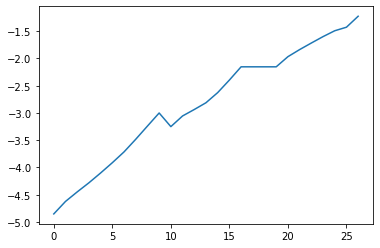

In [ ]:
import matplotlib.pyplot as plt

episodes = []

n_observations = env.observation_space.shape[0]
n_actions = env.action_space.shape[0]

i = 6
agent = HIRO(n_observations, n_actions).to(device)
load_model(agent, f"hiro_freeze_{i}")
episodes = get_intrinsic_reward(agent)

print("Freeze")

eps = np.array([np.array(l) for l in episodes])
#eps = np.mean(eps, 0)

plt.plot(eps[3])
plt.show()

95.64999999999947
Standard


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


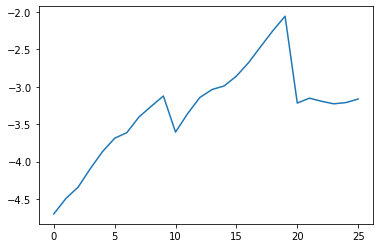

In [ ]:
episodes = []

n_observations = env.observation_space.shape[0]
n_actions = env.action_space.shape[0]

i = 3
agent = HIRO(n_observations, n_actions).to(device)
load_model(agent, f"hiro_{i}", "point_maze_time")
episodes = get_intrinsic_reward(agent)

print("Standard")

eps = np.array([np.array(l) for l in episodes])
#eps = np.mean(eps, 0)

plt.plot(eps[2])
plt.show()